In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [27]:
df = pd.read_csv('gold.csv')
df.shape

(3904, 7)

In [3]:
df.head()

,date,gold open,gold high,gold low,gold close,gold volume,eur_usd
0,2010-01-14,111.51,112.37,110.79,112.03,18305238.0,1.4478
1,2010-01-15,111.35,112.01,110.38,110.86,18000724.0,1.4376
2,2010-01-18,0.00,0.00,0.00,0.00,0.0,0.0000
3,2010-01-19,110.95,111.75,110.83,111.52,10467927.0,1.4269
4,2010-01-20,109.97,110.05,108.46,108.94,17534231.0,1.4094


In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
df['day'] = (df['date'] - df['date'].min()).dt.days + 1

In [6]:
df.head()

,date,gold open,gold high,gold low,gold close,gold volume,eur_usd,day
0,2010-01-14,111.51,112.37,110.79,112.03,18305238.0,1.4478,1
1,2010-01-15,111.35,112.01,110.38,110.86,18000724.0,1.4376,2
2,2010-01-18,0.00,0.00,0.00,0.00,0.0,0.0000,5
3,2010-01-19,110.95,111.75,110.83,111.52,10467927.0,1.4269,6
4,2010-01-20,109.97,110.05,108.46,108.94,17534231.0,1.4094,7


In [22]:
df.columns


Index(['date', 'gold open', 'gold high', 'gold low', 'gold close',
       'gold volume', 'eur_usd'],
      dtype='object')

In [28]:
df = df[['date', 'gold open', 'gold high', 'gold low', 'gold close',
       'gold volume', 'eur_usd']]

In [29]:
df.set_index('date', inplace=True)

In [30]:
df.columns

Index(['gold open', 'gold high', 'gold low', 'gold close', 'gold volume',
       'eur_usd'],
      dtype='object')

In [50]:
persentase_0 = (df['gold volume'] == 0).sum() / len(df) * 100
print(f"Persentase nilai 0: {persentase_0:.2f}%")


Persentase nilai 0: 4.74%


In [31]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [96]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)


In [97]:
def create_dataset(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])  # Mengambil 'gold close' sebagai target
    return np.array(X), np.array(y)

In [98]:

X, y = create_dataset(scaled_data)

In [99]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

In [100]:
train_size = int(len(X) * 0.8)  # 60% untuk train
test_size = len(X) - train_size

In [101]:

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [102]:
model = Sequential()
model.add(LSTM(64,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

e:\AI_Projek\GOLD\bakso2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [80]:
from tensorflow.keras.optimizers import RMSprop

In [103]:
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=7, batch_size=32)

Epoch 1/7
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.5427
Epoch 2/7
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.4455
Epoch 3/7
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4931
Epoch 4/7
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5038
Epoch 5/7
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4349
Epoch 6/7
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5210
Epoch 7/7
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5603


In [104]:
predictions = model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [94]:
def calculate_mape(y_true, y_pred):
    # Ganti nilai 0 dengan nilai kecil (epsilon) untuk menghindari pembagian dengan nol
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape


In [107]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

MAE: 0.5075464729119465
MSE: 0.9864670683954075
RMSE: 0.993210485443749
MAPE: 46.364082766581504%


In [72]:
# 7. Melakukan Prediksi
predictions = model.predict(X_test)

from sklearn.metrics import mean_squared_error

# Menghitung RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
RMSE: 0.1795303380839517


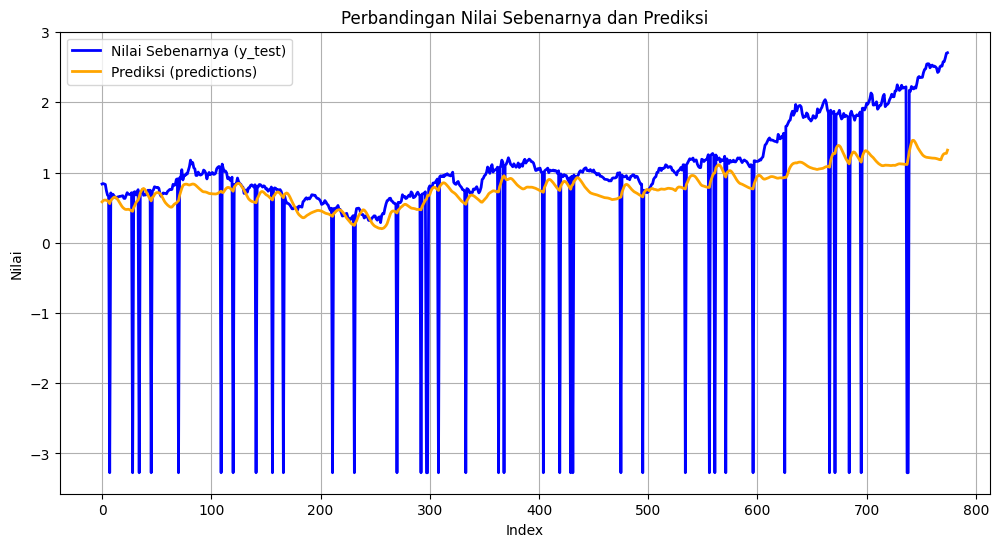

In [105]:
import matplotlib.pyplot as plt

# Misalkan y_test dan predictions sudah didefinisikan
# y_test = ...
# predictions = ...

# Membuat plot garis
plt.figure(figsize=(12, 6))

# Plot untuk y_test
plt.plot(y_test, label='Nilai Sebenarnya (y_test)', color='blue', linewidth=2)

# Plot untuk predictions
plt.plot(predictions, label='Prediksi (predictions)', color='orange', linewidth=2)

# Menambahkan label dan judul
plt.xlabel('Index')
plt.ylabel('Nilai')
plt.title('Perbandingan Nilai Sebenarnya dan Prediksi')
plt.legend()
plt.grid()

# Menampilkan plot
plt.show()

In [109]:
n = pd.DataFrame(y_test)
n.to_csv('y_test.csv')

c = pd.DataFrame(predictions)
c.to_csv('pred.csv')